In [1]:
import subprocess
import pdb

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
from nilearn.plotting import view_img_on_surf, view_img
from scipy.stats import ttest_1samp

import networkx as nx
from IPython.display import HTML

# import nest_asyncio
# nest_asyncio.apply()
# import datalad.api as dl

import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import scipy.io
from scipy import stats

from sklearn.manifold import MDS
import scipy.spatial.distance as sp_distance
from sklearn.preprocessing import RobustScaler, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D

import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
import matplotlib.pyplot as plt
import seaborn as sns 

from datetime import datetime as dt
from scipy.signal import hilbert, butter, filtfilt
from kuramoto import Kuramoto, plot_phase_coherence, plot_activity

%autosave 5
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

# %matplotlib notebook
%matplotlib inline
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")


/Users/gracer/opt/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/gracer/opt/anaconda3/envs/venv/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.

Autosaving every 5 seconds


Autosaving every 5 seconds


# Functions to register the images
Normal registrations lead to severe stretching an distortion of the functional images. Therefore, the ROIs (in MNI asym 09) and the T1 were registered to the functional image. While not standard, because this is an ROI analysis not whole brain we feel that this method is the best way to get the true areas of the ROIs in the functional images

In [ ]:
def get_t1(strc, basepath):
    T1 = strc
    sub = strc.split('/')[-1].split('.')[0].split('_')[-1]
    output_path = os.path.join(basepath,'derivatives','reg')
    return([sub,output_path,T1])

In [ ]:
def get_example_func(reference,T1,output_path,sub,style):
    example_func = '%s/%s_%s_example_func.nii.gz'%(output_path,sub,style)
    example_func_cmd = '/usr/local/fsl/bin/fslroi %s %s 300 1'%(reference,example_func)
    example_func_cmd_list= example_func_cmd.split(' ')
    subprocess.call(example_func_cmd_list)
    print(example_func)
    return(example_func)

In [ ]:
def func_thresh(example_func,output_path,sub):
    # threshold out extra bullshit
    print('thresholding')
    x = example_func.split('.')[0]
    x = '%s_thr'%x
    print(x)
    thr_cmd = '/usr/local/fsl/bin/fslmaths %s -thr 200 %s'%(example_func,x)
    thr_cmd_list = thr_cmd.split(' ')
    subprocess.call(thr_cmd_list)
    #example_func_thr = '%s/%s_example_func_thr.nii.gz'%(output_path,sub)
    example_func_thr = '%s.nii.gz'%x
    return(example_func_thr)

In [ ]:
def heavy_lifting(T1,example_func_thr, output_path, sub, basepath):
# register the T1 to the BOLD
    ## get the matrix
    print('welcome to the matrix')
    x = example_func.split('.')[0]
    outp = '%s_T12func.mat'%x
    cmd = 'flirt -in %s -ref %s -out outputvol -omat %s'%(T1,example_func_thr,outp)
    cmd_list = cmd.split(' ')
    subprocess.call(cmd_list)
    ## use the matrix
    print('neo use the matrix')
    matrix = outp
    y = '%s_T12func'%x
    flirt_cmd = 'flirt -in %s -ref %s -applyxfm -init %s -out %s'%(T1, example_func_thr,matrix,y)
    flrt_cmd_list = flirt_cmd.split(' ')
    subprocess.call(flrt_cmd_list)
    # Register the atlas image to the T1
    print('registering')
    T1_reg = y
    hi2std = '%s_highres2standard'%x
    hi2stdmat = '%s_highres2standard.mat'%x
    standard = os.path.join(basepath,'atlases','CIT168_Reinf_Learn_v1.1.0','MNI152-Nonlin-Asym-2009c','CIT168toMNI152-2009c_T1w_brain.nii.gz')
    s2t1_cmd = '/usr/local/fsl/bin/flirt -in %s -ref %s -out %s -omat %s -cost corratio -dof 12 -searchrx -90 90 -searchry -90 90 -searchrz -90 90 -interp trilinear'%(standard,T1_reg, hi2std,hi2stdmat)
    s2t1_cmd_list = s2t1_cmd.split(' ')
    subprocess.call(s2t1_cmd_list)
    return(hi2stdmat, T1_reg)

In [ ]:
def roi_dir(mask_dir, sub, style):
    roi_out = os.path.join(mask_dir,'%s_%s'%(style,sub))
    try:
        os.makedirs(roi_out)
    except FileExistsError:
        pass
    return(roi_out)


In [ ]:
def roi_create(roi_orig, roi_out, T1_reg, matrix):
    roi = roi_orig.split('/')[-1].split('_')[-1].split('.')[0]
    print(roi)
    ### align with the standard brain
    outp = '%s/%s_roi2T1'%(roi_out,roi)
    roi_cmd = 'flirt -in %s -ref %s -applyxfm -init %s -out %s'%(roi_orig,T1_reg,matrix,outp)
    print(roi_cmd)
    roi_cmd_list = roi_cmd.split(' ')
    subprocess.call(roi_cmd_list)
    return(outp, roi)

In [ ]:
def roi_thresh(roi,roi_out,thresh):
    inp ='%s/%s_roi2T1.nii.gz'%(roi_out,roi)
    oot = '%s/%s_%s_roi2T1_thresh'%(roi_out,roi,thresh)
    print(thresh)
    thresh_cmd = '/usr/local/fsl/bin/fslmaths %s -thr %s %s'%(inp,thresh,oot)
    print(thresh_cmd)
    thresh_cmd_list = thresh_cmd.split(' ')
    subprocess.run(thresh_cmd_list)
    num = roi.split('l')[1]
    oupt = '%s/%s_%s_roi2T1_thresh_bin'%(roi_out,roi,thresh)
    bin_cmd = 'fslmaths %s -bin -mul %s %s'%(oot,num,oupt)
    bin_cmd_list = bin_cmd.split(' ')
    subprocess.run(bin_cmd_list)
    return(oupt)

In [ ]:
def roi_merger(path2rois, thresh):
    ## make a total brain
    rois = glob.glob(os.path.join(path2rois,'vol*_%s_roi2T1_thresh_bin.nii.gz'%thresh))
    print(len(rois))
    finalgirl = os.path.join(path2rois,'total_rois')
    rois.append(finalgirl)
    roi_cmd2 = 'fslmaths %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s -add %s %s'%tuple(rois)
    roi_cmd2_list=roi_cmd2.split(' ')
    subprocess.run(roi_cmd2_list)
    
    
    
    
    
    

In [ ]:
def extractor(nifti, output):
    bet_cmd = 'bet %s %s -F'%(nifti, output)
    subprocess.run(['bet','%s'%nifti,'%s'%output,'-F'])

In [2]:
basepath = '/Users/gracer/Documents/BBC_21-2939_prepro_data'

In [3]:
tasks = ['base','clamp']

## need to register the two new ROIS to the same template as the others

In [ ]:
inp = os.path.join(basepath,'atlases','anatomical.nii.gz')
out = os.path.join(basepath,'atlases','anatomical_asym.nii.gz')
ref = os.path.join(basepath,'atlases','CIT168_Reinf_Learn_v1.1.0','MNI152-Nonlin-Asym-2009c','CIT168toMNI152-2009c_T1w_brain.nii.gz')
outmat = os.path.join(basepath,'atlases','anatomical_asym.mat')
fl_cmd = 'flirt -in %s -ref %s -out %s -omat %s'%(inp, ref, out,outmat)
fl_cmd_list = fl_cmd.split(' ')
subprocess.run(fl_cmd_list)


In [ ]:
inp = os.path.join(basepath,'atlases','dlpfc_association-test_z_FDR_0.01.nii.gz')
out = os.path.join(basepath,'atlases','atlas','CIT168toMNI152_prob_atlas_bilat_1mm__vol17')
ref = os.path.join(basepath,'atlases','CIT168_Reinf_Learn_v1.1.0','MNI152-Nonlin-Asym-2009c','CIT168toMNI152-2009c_T1w_brain.nii.gz')
inmat = os.path.join(basepath,'atlases','anatomical_asym.mat')
fl2_cmd = 'flirt -in %s -ref %s -out %s -init %s -applyxfm'%(inp, ref, out, inmat)
fl2_cmd_list = fl2_cmd.split(' ')
subprocess.run(fl2_cmd_list)


In [ ]:
inp = os.path.join(basepath,'atlases','visual_cortex_association-test_z_FDR_0.01.nii.gz')
out = os.path.join(basepath,'atlases','atlas','CIT168toMNI152_prob_atlas_bilat_1mm__vol18')
ref = os.path.join(basepath,'atlases','CIT168_Reinf_Learn_v1.1.0','MNI152-Nonlin-Asym-2009c','CIT168toMNI152-2009c_T1w_brain.nii.gz')
inmat = os.path.join(basepath,'atlases','anatomical_asym.mat')
fl3_cmd = 'flirt -in %s -ref %s -out %s -init %s -applyxfm'%(inp, ref, out, inmat)
fl3_cmd_list = fl3_cmd.split(' ')
subprocess.run(fl3_cmd_list)


In [ ]:
inp = os.path.join(basepath,'atlases','hippocampus_association-test_z_FDR_0.01.nii.gz')
out = os.path.join(basepath,'atlases','atlas','CIT168toMNI152_prob_atlas_bilat_1mm__vol19')
ref = os.path.join(basepath,'atlases','CIT168_Reinf_Learn_v1.1.0','MNI152-Nonlin-Asym-2009c','CIT168toMNI152-2009c_T1w_brain.nii.gz')
inmat = os.path.join(basepath,'atlases','anatomical_asym.mat')
fl4_cmd = 'flirt -in %s -ref %s -out %s -init %s -applyxfm'%(inp, ref, out, inmat)
fl4_cmd_list = fl4_cmd.split(' ')
subprocess.run(fl4_cmd_list)

## Needed to prethreshold these. They are from neurosyth and pick up a lot of excess areas

In [ ]:
inp = '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol19.nii.gz'
oot = '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/threshCIT168toMNI152_prob_atlas_bilat_1mm__vol19.nii.gz'
thresh = '10'
thresh_cmd = '/usr/local/fsl/bin/fslmaths %s -thr %s %s'%(inp,thresh,oot)
print(thresh_cmd)
thresh_cmd_list = thresh_cmd.split(' ')
subprocess.run(thresh_cmd_list)

In [ ]:
inp = '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol18.nii.gz'
oot = '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/threshCIT168toMNI152_prob_atlas_bilat_1mm__vol18.nii.gz'
thresh = '3'
thresh_cmd = '/usr/local/fsl/bin/fslmaths %s -thr %s %s'%(inp,thresh,oot)
print(thresh_cmd)
thresh_cmd_list = thresh_cmd.split(' ')
subprocess.run(thresh_cmd_list)

In [ ]:
inp = '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/CIT168toMNI152_prob_atlas_bilat_1mm__vol17.nii.gz'
oot = '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas/threshCIT168toMNI152_prob_atlas_bilat_1mm__vol17.nii.gz'
thresh = '6'
thresh_cmd = '/usr/local/fsl/bin/fslmaths %s -thr %s %s'%(inp,thresh,oot)
print(thresh_cmd)
thresh_cmd_list = thresh_cmd.split(' ')
subprocess.run(thresh_cmd_list)

# Skull stripping

In [ ]:
for task in tasks:
    print(task)
    for nifti in glob.glob(os.path.join(basepath,'func','%s'%task,'*.nii')):
        print(nifti)
        name = nifti.split('/')[-1].split('.')[0]
        output = os.path.join(basepath,'derivatives','BET','%s_brain'%name)
        extractor(nifti, output)

# Registration

## Try not to run unless you got time

In [ ]:
for strc in glob.glob(os.path.join(basepath, 'anat','ss_t1*.nii')):
    sub,output_path,T1 = get_t1(strc,basepath)
    print(sub)
    for task in tasks:
        for ref in glob.glob(os.path.join(basepath,'derivatives','BET','%s'%task,'*%s*_brain.nii.gz'%sub)):
            style = ref.split('_')[4]
            example_func = get_example_func(ref,T1,output_path,sub,style)
            example_func_thr = func_thresh(example_func,output_path,sub)
            matrix, T1_reg = heavy_lifting(T1, example_func_thr, output_path, sub, basepath)
            mask_dir = os.path.join(basepath,'atlases','atlas')
            for x in glob.glob(os.path.join(mask_dir,'CIT168toMNI152_prob_atlas_bilat_1mm__vol*.nii.gz')):
                
                roi_orig = os.path.join(mask_dir,x)
                roi_out = roi_dir(mask_dir, sub,style)
                roi_path,roi = roi_create(roi_orig, roi_out, T1_reg, matrix)
                roithr = roi_thresh(roi,roi_out,'0.5')


Exlcuding the PBP, VTA, SNr due to low signal. Need to fix roi_merger so it can predict the number of inputs

In [ ]:
for path2rois in glob.glob(os.path.join('/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas','*_*/')):
    print(path2rois)
    roi_merger(path2rois, '0.5')

# Parcellation 

In [ ]:
def parcellator(basepath, func, corrlabel):
    print("starting parcellation")
    corrtxt = os.path.join(basepath,'corrlabel_ts.txt')
    cmd = 'fslmeants -i %s --label=%s -o %s'%(func, corrlabel, corrtxt)
    cmd_list = cmd.split(' ')
    print(cmd_list)
    subprocess.run(cmd_list)

In [ ]:
outpath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output'
for task in tasks:
    for func in glob.glob(os.path.join(basepath,'derivatives','BET','%s'%task,'*_brain.nii.gz')):
        sub = func.split('/')[-1].split('_')[0].split('u')[-1]
        style = func.split('/')[-1].split('_')[1]
        print(sub)
        print(style)
        try:
            op = os.path.join(outpath,style,sub)
            os.makedirs(op)
        except FileExistsError:
            pass
        corrlabel = os.path.join('/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/atlas','%s_%s'%(style,sub),'total_rois.nii.gz')
        parcellator(op, func, corrlabel)


Slight overlap with hippocampus and the Nac and hippocampus and the putamen. Delete the last two columns 

# Correlations

In [ ]:
def correlations(outpath, txtfile):
    print('starting correlation')
    rtxt = os.path.join(outpath,'new_r_matrix.csv')
    ztxt = os.path.join(outpath,'new_zr_matrix.csv')
    corrtxt = os.path.join(outpath,txtfile)
    
    if os.path.isfile(corrtxt):        
#         timeseries = pd.read_csv(corrtxt, header=None,  skiprows=[0])
        timeseries = pd.read_csv(corrtxt, header = None, sep = '  ')
#         pdb.set_trace()
        timeseries = timeseries.drop([0], 1)
        timeseries = timeseries.apply(pd.to_numeric)
#         pdb.set_trace()
        myres = timeseries.corr(method='pearson')

        

        zrmaps = stats.zscore(myres, nan_policy='omit')
        
        pd.DataFrame(zrmaps).to_csv(ztxt, index=False, header= False)
        pd.DataFrame(myres).to_csv(rtxt, index=False, header= False)



# Insulin kinetics

In [ ]:
def ins_convert(insulin_units, mol):
    pmol = np.multiply(insulin_units, 6.0) 
    if mol == 'mol':
        mole = 1000
        mol = np.divide(pmol, mole)
        return(mol)
    else:
        return(mol)

In [ ]:
path2insulin = os.path.join('/Users/gracer/Documents/BBC_21-2939_insulin','*.csv')
converted_ins = []
for sub in glob.glob(path2insulin):
    print(sub)
    df = pd.read_csv(sub, sep = ',', encoding='latin-1')
    converted_ins.append(df)
    
    
ins_conv_df = pd.concat(converted_ins)

In [ ]:
ins_conv_df['insulin_pmol'] = ins_convert(ins_conv_df['insulin_uIU_mL'],'mol')

In [ ]:
plt.figure(figsize=(16, 8), dpi=150)

ins_conv_df.loc[ins_conv_df['pid'] == 20001]['insulin_pmol'].plot(label='%s phase 20004'%roi, color = 'violet')

# adding title to the plot
plt.title('ROI phase')

# adding Label to the x-axis
plt.xlabel('time')

# adding legend to the curve
plt.legend()

# Standardizing the timeseries (brain and insulin seperately)

Switch to both robust, ~~then seperate the negative (abs) and postive values~~, then run through the pipeline.
4/27 had to switch both to standard cause robust obliterated the insulin

In [4]:
def combo(path2ts, path2insulin, outpath, instatus):
    prets = pd.read_csv(path2ts, sep = '  ', header = None)
    print(prets.shape)
    x = prets.shape[1]
    if x > len(heads):
#         pdb.set_trace()
        if x - len(heads) == 2:
            cols = [-2,-1]
            prets = prets.drop(prets.columns[cols],axis=1)
        if x - len(heads) == 1:
            cols = [-1]
            prets = prets.drop(prets.columns[cols],axis=1)
    transformer = StandardScaler().fit(prets)
    ts = pd.DataFrame(data = transformer.transform(prets))
    ts = ts.set_axis(heads, axis=1, inplace=False)
    ts['TR'] = ts.index
    ts['TR'] = pd.to_datetime(ts['TR'], unit='s')
    ts_downsamp = ts.set_index('TR').resample('60S').mean().dropna().reset_index()
    ts_downsamp = ts_downsamp.rename({'TR': 'time'}, axis=1)
    df = ts_downsamp
    print(df.shape)
    
    if instatus == "clamp":
        in_ts = pd.read_csv(path2insulin, sep = ',', encoding='latin-1')
        ins = np.array(in_ts['insulin_uIU_mL']).reshape(-1, 1)
        inscaler = StandardScaler()
        X = pd.DataFrame(inscaler.fit_transform(ins))
        
        gluc = np.array(in_ts['glucose_mg_dL']).reshape(-1, 1)
        gluscaler = StandardScaler()
        Y = pd.DataFrame(gluscaler.fit_transform(gluc))

        in_ts['insulin_uIU_mL'] = X
        in_ts['glucose_mg_dL'] = Y
        
        in_ts['time'] = in_ts['time'] - 1
        in_ts['time'] = pd.to_datetime(in_ts['time'], unit='m')

        df = pd.merge(df, in_ts, on='time', how='outer')
        df = df.drop(['label','sex','pid'], 1)
        df.drop(df.index[:4], inplace=True)
        
    fp = outpath
    df.to_csv(fp, index=False)

In [5]:
labels = '/Users/gracer/Documents/BBC_21-2939_prepro_data/atlases/CIT168_Reinf_Learn_v1.1.0/labels.csv'
bbasepath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base'
clamppath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp'
ppath = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/'

In [6]:
ROI_names = pd.read_csv(labels,sep = ',')
heads = list(ROI_names['ROI'])

In [7]:
for task in tasks:
    for sub_path in glob.glob(os.path.join(ppath,'%s'%task,'*')):
        print(sub_path)
        sub = sub_path.split('/')[-1]
        style = sub_path.split('/')[-2]
        path2ts = os.path.join(sub_path,'corrlabel_ts.txt')
        path2insulin = os.path.join('/Users/gracer/Documents/BBC_21-2939_insulin','%s.csv'%sub)
        outpath = os.path.join(sub_path,'total_ts.csv')
        combo(path2ts, path2insulin, outpath, style)

/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20008
(600, 21)
(10, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20001
(600, 21)
(10, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20002
(600, 21)
(10, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20003
(600, 21)
(10, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20004
(600, 20)
(10, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/base/20010
(600, 21)
(10, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20008
(2784, 21)
(47, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20001
(2794, 21)
(47, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20002
(3600, 21)
(60, 20)
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20003
(3600, 21)
(60, 20)
/Users/gracer/Document

In [ ]:
for task in tasks:
    for outpath in glob.glob(os.path.join(ppath,'%s'%task,'*')):
        sub = outpath.split('/')[-1]
        print(sub)
        txtfile = 'corrlabel_ts.txt'
        correlations(outpath, txtfile)

In [8]:
sub_timeseries_w_na = {}
for txtfile in glob.glob(os.path.join(clamppath,'*','total_ts.csv')):
    print(txtfile)
    df = pd.read_csv(txtfile)
    sub = txtfile.split('/')[-2]
#     df.reset_index(inplace=True, drop=True)
    df = df.set_index('time')
    df = df.drop(['PBP','VTA','SNr','glucose_mg_dL'], 1)
    sub_timeseries_w_na[sub] = df


/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20008/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20001/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20002/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20003/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20004/total_ts.csv
/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/output/clamp/20010/total_ts.csv


In [9]:
def get_subject_roi(data, roi):
    sub_rois = {}
    for sub in data:
        sub_rois[sub] = data[sub][roi]
    return pd.DataFrame(sub_rois)

In [10]:
heady = list(sub_timeseries_w_na['20001'].columns.values)

In [11]:
sub_timeseries = {}
for sub,data in sub_timeseries_w_na.items():
    print(sub)
    sub_timeseries[sub] = data.dropna()

20008
20001
20002
20003
20004
20010


In [ ]:
bg_img = '/Users/gracer/Documents/BBC_21-2939_prepro_data/derivatives/reg/20004_base_example_func_T12func.nii.gz'

## Time syncrony

I think this is the way to go but I need to standardized the insulin data and the brain seperately then put them together so they are in the same metrics

https://naturalistic-data.org/content/Intersubject_Correlation.html#intersubject-phase-synchrony-tutorial

In [39]:
def _phase_vector_length_sine_only(phase_angles):
    """
    Only going to get the sine of the phase_angles
    Compute vector length of phase angles using circular statistics

    Can take 1D (observation for a single feature) or 2D (observation x feature) signals

    Implementation from:

        Fisher, N. I. (1995). Statistical analysis of circular data. cambridge university press.

    Args:
        phase_angles: (np.array) 1D or 2D array of phase angles

    Returns:
         phase angle vector length: (np.array)

    """

    axis = 0 if len(phase_angles.shape) == 1 else 1
    return np.float32(
#             np.mean(np.cos(phase_angles), axis=axis) ** 2 +
              np.mean(np.sin(phase_angles), axis=axis))

In [40]:
def b_bandpass_filter(data, low_cut, high_cut, fs, axis=0, order=5):
    """
    Apply a bandpass butterworth filter with zero-phase filtering

    Args:
        data: (np.array)
        low_cut: (float) lower bound cutoff for high pass filter
        high_cut: (float) upper bound cutoff for low pass filter
        fs: (float) sampling frequency in Hz
        axis: (int) axis to perform filtering.
        order: (int) filter order for butterworth bandpass

    Returns:
        bandpass filtered data.
    """
    nyq = 0.5 * fs
    b, a = butter(order, [low_cut / nyq, high_cut / nyq], btype="band")
    return filtfilt(b, a, data, axis=axis)

In [41]:
def isps_insulin(data, pairwise=False):
    #Updated with sine only phase 
    if not isinstance(data, (pd.DataFrame, np.ndarray)):
        raise ValueError("data must be a pandas dataframe or numpy array (observations by subjects)")
    phase = np.angle(hilbert(pd.DataFrame(data), axis=0))
    out = {"average_angle": _phase_mean_angle(phase)}
    out["vector_length"] = _phase_vector_length_sine_only(phase)
    return out


# About frequencies
* intrinsic mode functions (IMFs)
* variational mode decomposition (VMD)  
(1) estimate individual IMFs by computing the Hilbert transform of the original signal f  
(2) shift each mode to its base frequency using heterodyne demodulation  
(3) estimate the bandwidth of each mode as the H1 Gaussian smoothness of the demodulated signal.

The frequencies used in this analysis are dervived from (10.3389/fnins.2019.00900). They found 4 frequencies. 
* VMD IMF1: 0.20–0.24 Hz
* VMD IMF2: 0.13–0.17 Hz
* VMD IMF3: 0.063–0.098 Hz
* VMD IMF4: 0.021–0.036 Hz  
Their results are summarized here: IMF4 being the most stable across brain regions and IMF2 being the least. Highest correlations between brain regions are found using IMF4, followed by IMF3, while no strong patterns were seen for IMFs 1 and 2. We have identified the frequency cluster IMF3 as most representative of neutrally relevant BOLD, both by frequency and by spatial contribution.

In [ ]:
# tr = 1
# roi = 'Pu'

# frequencies = [(0.01, 0.027),(0.027, 0.073),(0.073, 0.198),(0.198, 0.25)]

# time_freq = {}
# for i,cutoff in enumerate(frequencies):
#     time_freq[i] = isps(get_subject_roi(sub_timeseries, roi).dropna(), low_cut=cutoff[0], high_cut=cutoff[1], sampling_freq=1/tr, order=5)
    

# Get the phases of the rois
This will get the phases for each roi per subject. This is using a bandpass filter and the hilbert transform in line with previous methods. 

In [ ]:
phaze = {}
tr = 1
time = {}
out = {}
frequencies = [(0.021, 0.036),(0.063, 0.098),(0.13, 0.17),(0.2, 0.25)]
frq = ['IMF4: 0.021–0.036 Hz','IMF3: 0.063–0.098 Hz','IMF2: 0.13–0.17 Hz','IMF1: 0.20–0.25 Hz']
for roi in heady[0:-1]:
    print(roi)
    df = get_subject_roi(sub_timeseries, roi).dropna()
    names = df.columns
    time[roi] = df.index
    phaze[roi]={}
    for name in names:
        phaze[roi][name]={}
        for x, freq in enumerate(frequencies):
            phaze[roi][name][frq[x]] = np.angle(
                hilbert(b_bandpass_filter(get_subject_roi(sub_timeseries, roi).dropna()[name], low_cut=freq[0], high_cut=freq[1], fs=1/tr, order=5), 
                        axis=0,))




# Get insulin phase
This is a hilbert transform to smooth the insulin time series. This produces a smooth insulin curve per subject. We will refer to this as the phase

In [ ]:
insulin_df = get_subject_roi(sub_timeseries, 'insulin_uIU_mL').dropna()
subs = insulin_df.columns
in_sync = {}
for x in subs:
    in_sync[x] = np.angle(hilbert(insulin_df[x], axis=0))

In [ ]:
df_ins = pd.DataFrame.from_dict(in_sync)

In [83]:
def _phase_rayleigh_p(phase_angles):
    """Compute the p-value of the phase_angles using the Rayleigh statistic

    Note: this test assumes every time point is independent, which is unlikely to be true in a timeseries with autocorrelation

    Implementation from:

        Fisher, N. I. (1995). Statistical analysis of circular data. cambridge university press.

    Args:
        phase_angles: (np.array) 1D or 2D array of phase angles

    Returns:
         p-values: (np.array)

    """

    n = len(phase_angles) if len(phase_angles.shape) == 1 else phase_angles.shape[1]

    Z = n * _phase_vector_length(phase_angles) ** 2
    if n <= 50:
        return np.exp(-1 * Z) * (
            1
            + (2 * Z - Z ** 2) / (4 * n)
            - (24 * Z - 132 * Z ** 2 + 76 * Z ** 3 - 9 * Z ** 4) / (288 * n ** 2)
        )
    else:
        return np.exp(-1 * Z)

# Get the phase vector length of insulin and ROI
~~Here we combine the smoothed insulin phases and the filtered and smoothed ROI phases on a per ROI bases. This means the 4 insulin curves (1 per subject) are combined with the 4 ROI curves (1 per subject). We then calculate the phase vector length. A small phase vector length means the curves are not similar, a large phase vector length means the curves are in the same direction. ~~


Going to do this pairwise with 1 insulin curve and 1 ROI persubject

In [ ]:
len(in_sync['20008'])

In [ ]:
phaze.keys()

In [ ]:
faze = {}
p_faze = {}
kura = {}
for roi,subs in phaze.items():
    print(roi)
    faze[roi]={}
    p_faze[roi]={}
    kura[roi]={}
    for sub, freq in subs.items():
        print(sub)
        faze[roi][sub]={}
        p_faze[roi][sub]={}
        kura[roi][sub]={}
        for hz, df in freq.items():
#             print(frq)
            allphase = np.hstack((in_sync[sub], df))
            allphase = np.reshape(allphase, (40,2))
#             plot_activity(allphase.T)
#             plot_phase_coherence(allphase.T)
            kura[roi][sub][hz] = [Kuramoto.phase_coherence(vec) for vec in allphase]
            out = {"average_angle": _phase_mean_angle(allphase)}
            faze[roi][sub][hz]=_phase_vector_length_sine_only(allphase)
            p_faze[roi][sub][hz] = _phase_rayleigh_p(allphase)

In [ ]:
kura['Pu']['20008']


# Plots of phase similarity
These plots show the similarity between the insulin and ROI curves at different frequency bands of the ROI signal (we are assuming there is only a single band of insulin). Yellow indicates high syncronicity and black means no syncronicity. The larger bands show little similarity and are usually "noise"

In [ ]:
total_df = []
for sub, data in faze['HTH'].items():
    x = pd.DataFrame.from_dict(data)
    x['sub'] = sub
    total_df.append(x)
#     for freq, df in data.items():
#         total_df.

In [ ]:
sync_df = pd.concat(total_df)

In [ ]:
plt.hist(sync_df['IMF3: 0.063–0.098 Hz'], bins='auto')

In [ ]:
sync_df

# Potential interpretations 

possible saturation of insulin rt == pattern of sync? in and out of sync? need the switch between saturation at the level of the hypothalamus. Check Km value of CNS insulin receptor. Check lit on difference in fMRI frequencies.    

# To do

* Sync graph across all subs, hypothalamus, hippo, and visual 
* Sync with glucose 
* connectivity and hth late breakings 


In [ ]:
heady

In [ ]:
frq = 'IMF3: 0.063–0.098 Hz'
roi = 'HTH'

In [ ]:
total_df = []
for sub, data in phaze[roi].items():
    x = pd.DataFrame.from_dict(data)
    x['sub'] = sub
    x['time'] = time[roi]
    x['time'] = pd.to_datetime(x['time'])
    x['time'] = x['time'].dt.strftime('%H:%M:%S')
    x = x.set_index('time')
    total_df.append(x)
df = pd.concat(total_df)

In [ ]:
total_df1 = []
for sub, data in faze[roi].items():
    x = pd.DataFrame.from_dict(data)
    x['sub'] = sub
    x['time'] = time[roi]
    x['time'] = pd.to_datetime(x['time'])
    x['time'] = x['time'].dt.strftime('%H:%M:%S')
    x = x.set_index('time')
    total_df1.append(x)
sync_df = pd.concat(total_df1)

In [ ]:

plt.figure(figsize=(16, 8), dpi=150)

# sync_df.loc[sync_df['sub'] == '20001'][frq].plot(label='20001', color = 'red')
sync_df.loc[sync_df['sub'] == '20002'][frq].plot(label='20002', color = 'blue')
sync_df.loc[sync_df['sub'] == '20003'][frq].plot(label='20003', color = 'green')
sync_df.loc[sync_df['sub'] == '20004'][frq].plot(label='20004', color = 'purple')
sync_df.loc[sync_df['sub'] == '20008'][frq].plot(label='20008', color = 'orange')
#     df.loc[df['sub'] == '20010'][x].plot(label='20010', color = 'black')

# adding title to the plot
plt.title('Synchronicity')

# adding Label to the x-axis
plt.xlabel('time')

# adding legend to the curve
plt.legend()

In [ ]:
plt.figure(figsize=(16, 8), dpi=150)

# df.loc[df['sub'] == '20001'][frq].plot(label='20001', color = 'purple')
df.loc[df['sub'] == '20002'][frq].plot(label='20002', color = 'fuchsia')
# df.loc[df['sub'] == '20004'][frq].plot(label='20004', color = 'deeppink')
# df.loc[df['sub'] == '20010'][frq].plot(label='%s phase 20010'%roi, color = 'violet')
# df_ins['20001'].plot(label='20001', color = 'forestgreen')
df_ins['20002'].plot(label='20002', color = 'limegreen')
# df_ins['20004'].plot(label='20003', color = 'greenyellow')
# df_ins['20010'].plot(label='insulin phase 20010', color = 'green')

# sync_df.loc[sync_df['sub'] == '20010'][frq].plot(label='sync 20010', color = 'black')
# sync_df.loc[sync_df['sub'] == '20004'][frq].plot(label='sync 20004', color = 'lightblue')

# sync_df.loc[sync_df['sub'] == '20001'][frq].plot(label='sync 20001', color = 'violet')
# sync_df.loc[sync_df['sub'] == '20002'][frq].plot(label='sync 20002', color = 'limegreen')

# sync_df.loc[sync_df['sub'] == '20003'][frq].plot(label='sync 20003', color = 'orange')
# sync_df.loc[sync_df['sub'] == '20004'][frq].plot(label='sync 20004', color = 'deeppink')

# sync_df.loc[sync_df['sub'] == '200048'][frq].plot(label='sync 20008', color = 'purple')

#     df.loc[df['sub'] == '20008'][x].plot(label='20008', color = 'orange')
#     df.loc[df['sub'] == '20010'][x].plot(label='20010', color = 'black')

# adding title to the plot
plt.title('ROI phase')

# adding Label to the x-axis
plt.xlabel('time')

# adding legend to the curve
plt.legend()

In [ ]:
for roi, dat in faze.items():
    sync_df = []
    for sub, data in dat.items():
        x = pd.DataFrame.from_dict(data)
        x['sub'] = sub
        x['time'] = time[roi]
        x['time'] = pd.to_datetime(x['time'])
        x['time'] = x['time'].dt.strftime('%H:%M:%S')
        x = x.set_index('time')
        sync_df.append(x)
    sync_df = pd.concat(sync_df)
    sync_df.to_csv(os.path.join(basepath,'derivatives','output','dfs','sync_%s.csv'%roi))  

# Kuramoto

In [ ]:
from kuramoto import Kuramoto, plot_phase_coherence, plot_activity


In [ ]:
kura.keys()

In [ ]:
for roi, dat in kura.items():
    k_df = []
    for sub, data in kura[roi].items():
        x = pd.DataFrame.from_dict(data)
        x['sub'] = sub
        x['time'] = time[roi]
        x['time'] = pd.to_datetime(x['time'])
        x['time'] = x['time'].dt.strftime('%H:%M:%S')
        x = x.set_index('time')
        k_df.append(x)
    kura_df = pd.concat(k_df)
    kura_df.to_csv(os.path.join(basepath,'derivatives','output','dfs','kuramoto_%s.csv'%roi))  

In [ ]:
basepath

In [ ]:
kura_df = pd.concat(k_df)

In [ ]:
plt.figure(figsize=(16, 8), dpi=150, facecolor='white')
frq = 'IMF3: 0.063–0.098 Hz'
colors = ['mediumblue', 'teal','deeppink','firebrick','forestgreen','dodgerblue']
i = 0 
for sub, data in kura['HTH'].items():
    print(sub)
    print(i)
    kura_df.loc[kura_df['sub'] == sub][frq].plot(label='%s'%sub, color = '%s'%colors[i], marker = 'o')
    i = i+1

# adding title to the plot
plt.title('Order parameter Rt over time')

# adding Label to the x-axis
plt.xlabel('time')
plt.ylabel('Kuramoto rder parameter (Rt)')

# ax.set_facecolor('white')

# adding legend to the curve
plt.legend()

In [ ]:
big_df = []
frq = 'IMF3: 0.063–0.098 Hz'
for ROI, dat in kura.items():
    print(dat.keys())
    for sub, data in dat.items():
        df = pd.DataFrame({'time':time['%s'%ROI],'sub':sub,'roi':ROI, '%s'%frq:data[frq]})
        big_df.append(df)

In [ ]:
all_df = pd.concat(big_df)

In [ ]:
k_df = []
for sub, data in kura['Hippo'].items():
    x = pd.DataFrame.from_dict(data)
    x['sub'] = sub
    x['time'] = time['HTH']
    x['time'] = pd.to_datetime(x['time'])
    x['time'] = x['time'].dt.strftime('%H:%M:%S')
    x = x.set_index('time')
    k_df.append(x)
kura_df = pd.concat(k_df)

In [ ]:
frq = 'IMF3: 0.063–0.098 Hz'
r = 2
step = 5

a = all_df['sub'].unique()
b = all_df['roi'].unique()
keep = []
for sub in a:
    for roi in b:
        keep.append(all_df.loc[(all_df['sub'] == sub) & (all_df['roi'] == roi)][all_df.loc[(all_df['sub'] == sub) & (all_df['roi'] == roi)][frq].round(r).eq(all_df[(all_df['sub'] == sub) & (all_df['roi'] == roi)][frq].shift().round(r)).rolling(step).sum().eq(step)])

onset_df = pd.concat(keep)


In [ ]:
onset_df['Time 2'] = pd.to_datetime(onset_df['time']).values.astype(np.int64)

In [ ]:
y = onset_df.groupby('roi')['Time 2'].max() - onset_df.groupby('roi')['Time 2'].min()
len_sync = pd.to_datetime(y, unit='ns')
len_sync

# Null models

## Phase Randomization
Going to use phase randomization to generate a randome surrogate of the data. This should maintain the temporal and autoregressive structure of the data. Will need to figure out how to do this with the insulin data

In [33]:
# def so_random(roi):
#     randoms = {roi: {}}
#     sub_rois = get_subject_roi(sub_timeseries, '%s'%roi)
#     subs = list(sub_rois.columns)
#     for sub in subs:
#         it = list(range(0, 50000))
#         so_ran = []
#         for x, y in enumerate (it): 
#             so_ran.append(phase_randomize(sub_rois['%s'%sub].dropna()))
#         randoms[roi][sub] = np.mean(so_ran, axis=0)
#     return(randoms)

In [52]:
list(sub_timeseries.keys())

['20008', '20001', '20002', '20003', '20004', '20010']

In [97]:
def so_random(sub):
    randoms = {sub: {}}
    for roi in heady:
        sub_rois = get_subject_roi(sub_timeseries, '%s'%roi).dropna()
        it = list(range(0, 500000))
        so_ran = []
        for x, y in enumerate (it): 
            so_ran.append(phase_randomize(sub_rois['%s'%sub]))
        randoms[sub][roi] = np.mean(so_ran, axis=0)
    return(randoms)

In [98]:
from tqdm import tqdm
from multiprocess import Pool

max_pool = 5
subs = list(sub_timeseries.keys())
with Pool(max_pool) as p:
    pool_outputs = list(tqdm(p.imap(so_random, subs),total=len(subs)))    

total_null ={}
for x in pool_outputs:
    key, value = list(x.items())[0]
    total_null[key] = value

100%|████████████████████████████████████████████| 6/6 [10:20<00:00, 103.43s/it]


In [130]:
sub_timeseries['20008']

,Pu,Ca,NAC,EXA,GPe,GPi,SNc,RN,VeP,HN,HTH,MN,STH,dlPFC,Viz,Hippo,insulin_uIU_mL
time,,,,,,,,,,,,,,,,,
1970-01-01 00:04:00,-0.462672,-0.869014,0.226368,-1.074743,-0.615625,-0.545462,0.0,-0.667037,0.139342,0.106423,-0.682427,-0.973980,-0.371556,-0.321956,-0.798462,-0.668082,-1.791093
1970-01-01 00:05:00,-0.671698,-0.920703,0.035798,-1.073833,-0.764601,-0.753423,0.0,-0.779403,-0.082817,-0.174632,-0.792110,-1.064130,-0.654201,-0.603058,-0.961832,-0.835886,0.174741
1970-01-01 00:06:00,-0.583584,-0.850192,0.075293,-1.059046,-0.758427,-0.781183,0.0,-0.524688,-0.149038,0.028631,-0.717994,-1.009972,-0.423792,-0.681763,-0.721282,-0.778056,-1.791093
1970-01-01 00:07:00,-0.704805,-0.991514,-0.009362,-1.026744,-0.804856,-0.841999,0.0,-0.661842,-0.146902,-0.124444,-0.722301,-1.026791,-0.576453,-0.920279,-1.113894,-0.938572,0.174741
1970-01-01 00:08:00,-0.672815,-0.918455,0.003286,-0.992166,-0.870749,-0.850744,0.0,-0.501755,-0.192829,0.081329,-0.587560,-0.928568,-0.334504,-0.681740,-0.631533,-0.802823,0.174741
1970-01-01 00:09:00,-0.577133,-0.868534,0.218299,-0.709178,-0.673800,-0.750214,0.0,-0.268638,0.020786,-0.134481,-0.287692,-0.576378,-0.328228,-0.935163,-0.786052,-0.797219,0.174741
1970-01-01 00:10:00,-0.083889,-0.482225,0.977167,-0.186424,0.130369,0.041836,0.0,1.545461,0.829319,0.962136,0.979542,0.799082,1.096739,-0.559575,-0.486287,-0.437798,0.174741
1970-01-01 00:11:00,-0.525306,-0.616430,0.616976,-0.350439,-0.584972,-0.666211,0.0,0.198710,0.211971,-0.247405,0.202782,-0.091654,-0.311221,-0.303436,-0.880557,-0.880427,0.174741
1970-01-01 00:12:00,-0.745214,-0.956105,0.218221,-0.737614,-0.840782,-0.965315,0.0,-0.437631,-0.146902,-0.463216,-0.429570,-0.648027,-0.611885,-1.006505,-0.813540,-0.891800,0.174741


In [131]:
pd.DataFrame.from_dict(total_null['20008'])

,Pu,Ca,NAC,EXA,GPe,GPi,SNc,RN,VeP,HN,HTH,MN,STH,dlPFC,Viz,Hippo,insulin_uIU_mL
0,0.045416,0.059083,-0.007780,0.062947,0.040028,0.031608,0.0,0.117232,-0.010311,0.044202,0.089857,0.114761,0.091226,0.032909,0.122685,0.038958,-0.318175
1,0.065997,0.132789,-0.038643,0.160461,0.068936,0.066971,0.0,0.089522,-0.021498,-0.011499,0.124712,0.141595,0.067662,0.034458,0.114252,0.096227,0.269660
2,0.044946,0.059312,-0.007651,0.062354,0.040507,0.032121,0.0,0.115606,-0.009476,0.044395,0.089675,0.114876,0.089587,0.033372,0.122144,0.037286,-0.318350
3,0.064337,0.133263,-0.039059,0.159973,0.068766,0.067646,0.0,0.088218,-0.021065,-0.011218,0.123259,0.142156,0.067072,0.034300,0.113597,0.094294,0.271631
4,0.044060,0.060993,-0.007221,0.061836,0.039005,0.032285,0.0,0.116739,-0.009249,0.045049,0.088336,0.115444,0.089683,0.033830,0.120651,0.036103,-0.317180
5,0.063679,0.135333,-0.038650,0.158874,0.067824,0.067512,0.0,0.090316,-0.021289,-0.011956,0.123479,0.141427,0.067037,0.034744,0.113930,0.095002,0.273571
6,0.044432,0.061978,-0.008021,0.060632,0.039318,0.032015,0.0,0.117170,-0.009553,0.044920,0.089485,0.114276,0.089119,0.033344,0.121678,0.037096,-0.317698
7,0.064466,0.135542,-0.039871,0.159026,0.068585,0.067581,0.0,0.090014,-0.021413,-0.011276,0.124242,0.141650,0.066919,0.034034,0.113177,0.096183,0.273140
8,0.045640,0.060811,-0.006774,0.061356,0.039578,0.031579,0.0,0.116403,-0.009941,0.045215,0.089336,0.114883,0.088966,0.032343,0.121918,0.038523,-0.315480
9,0.065177,0.134594,-0.038423,0.159128,0.068635,0.067415,0.0,0.087236,-0.021817,-0.010414,0.124446,0.142560,0.066617,0.033397,0.113364,0.096634,0.274538


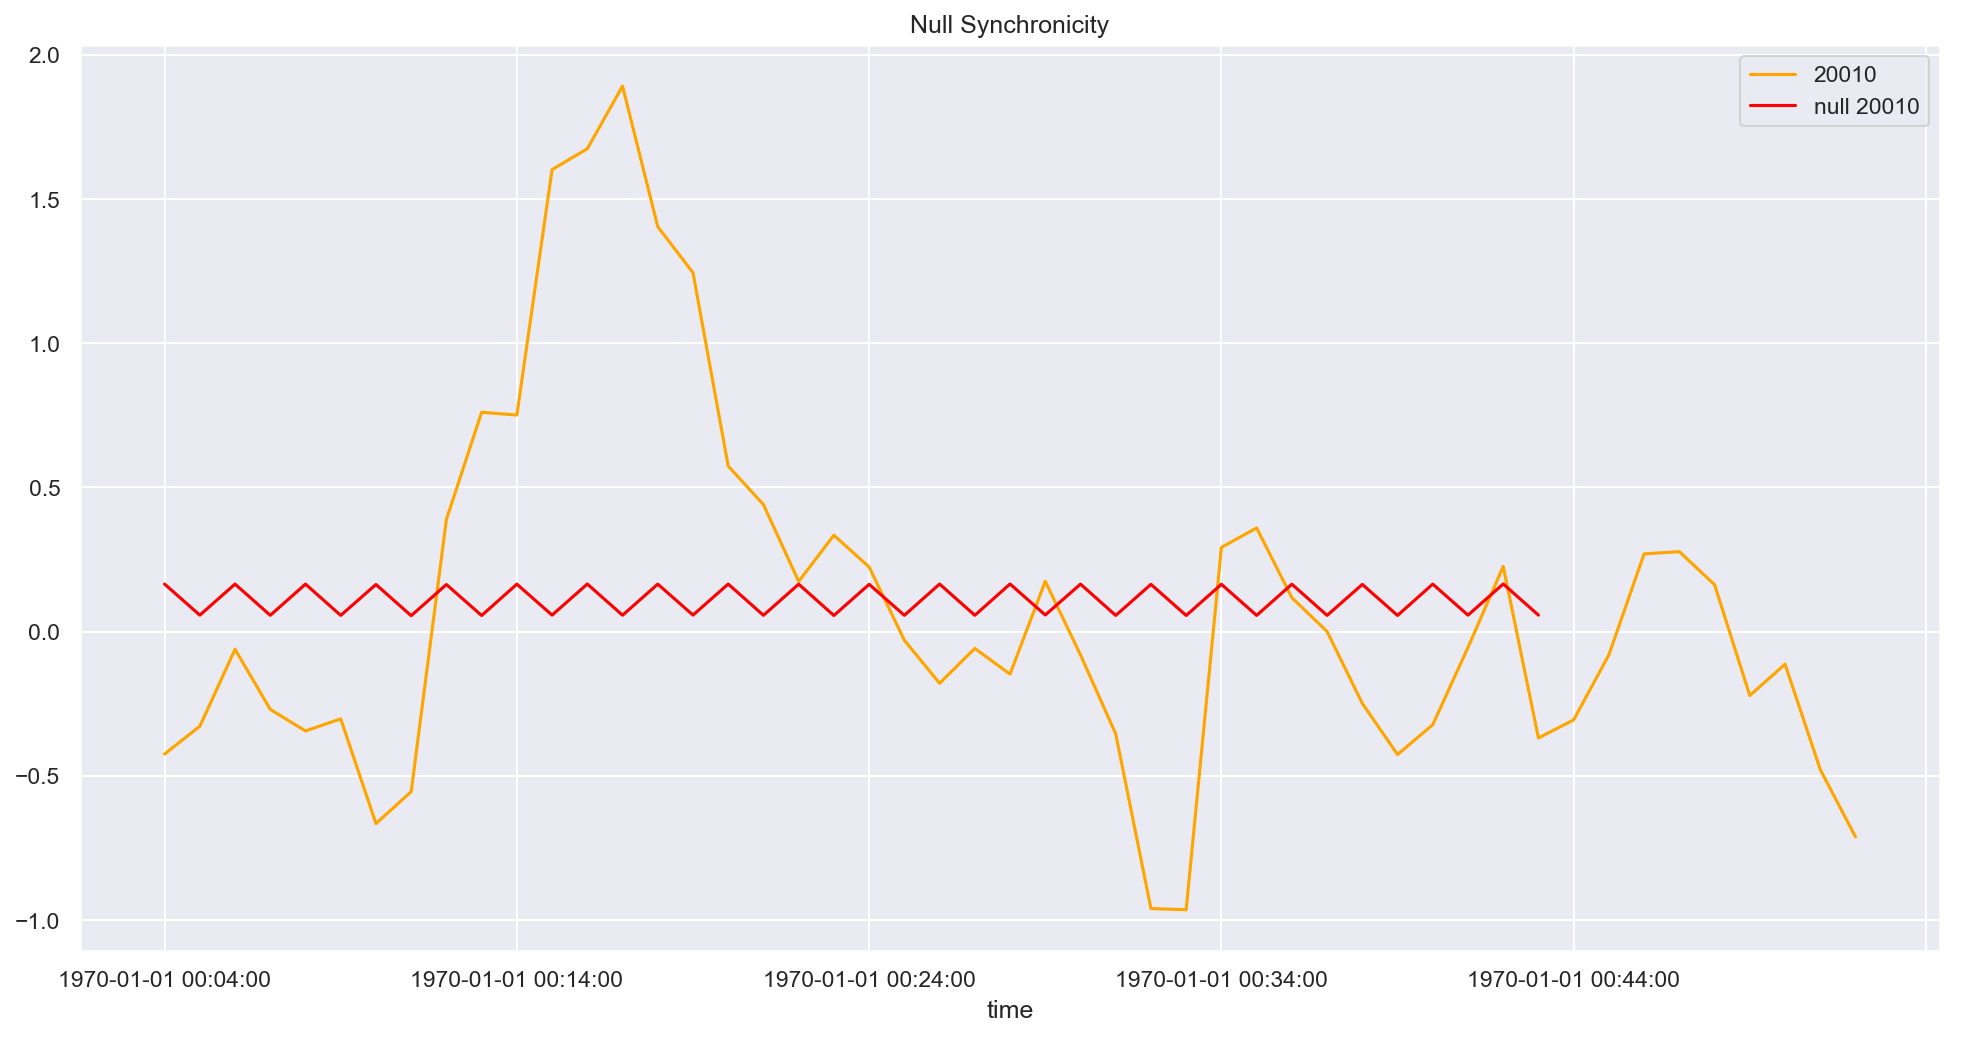

In [141]:
sub = '20010'
roi = 'Pu'
plt.figure(figsize=(16, 8), dpi=150)

sub_timeseries['%s'%sub]['%s'%roi].plot(label='%s'%sub, color = 'orange')
pd.DataFrame.from_dict(total_null['%s'%sub])['%s'%roi].plot(label='null %s'%sub, color = 'red')

# adding title to the plot
plt.title('Null Synchronicity')

# adding Label to the x-axis
plt.xlabel('time')

# adding legend to the curve
plt.legend()

In [99]:
null_phaze = {}
tr = 1
time = {}
out = {}
frequencies = [(0.021, 0.036),(0.063, 0.098),(0.13, 0.17),(0.2, 0.25)]
frq = ['IMF4: 0.021–0.036 Hz','IMF3: 0.063–0.098 Hz','IMF2: 0.13–0.17 Hz','IMF1: 0.20–0.25 Hz']
for roi in heady[0:-1]:
    print(roi)
    df = get_subject_roi(total_null, roi)
    names = df.columns
    time[roi] = df.index
    null_phaze[roi]={}
    for name in names:
        null_phaze[roi][name]={}
        for x, freq in enumerate(frequencies):
            null_phaze[roi][name][frq[x]] = np.angle(
                hilbert(b_bandpass_filter(get_subject_roi(total_null, roi).dropna()[name], low_cut=freq[0], high_cut=freq[1], fs=1/tr, order=5), 
                        axis=0,))



Pu
Ca
NAC
EXA
GPe
GPi
SNc
RN
VeP
HN
HTH
MN
STH
dlPFC
Viz
Hippo


In [127]:
null_phaze

{'Pu': {'20008': {'IMF4: 0.021–0.036 Hz': array([-1.86547487, -1.41837766, -1.12703426, -0.92478587, -0.69663072,
          -0.52534917, -0.32479065, -0.1642022 ,  0.020715  ,  0.1775104 ,
           0.35291068,  0.5095755 ,  0.67958326,  0.838739  ,  1.00685371,
           1.17084295,  1.3406592 ,  1.5118622 ,  1.68753967,  1.86837615,
           2.05479188,  2.24717938,  2.44918714,  2.65297482,  2.87267101,
           3.08304603, -2.96816389, -2.76187878, -2.53262614, -2.34292339,
          -2.13495198, -1.96966604, -1.79714606, -1.65820911, -1.53062646,
          -1.41709137, -1.34503784, -1.25186033, -1.25586025, -1.0907492 ]),
   'IMF3: 0.063–0.098 Hz': array([-1.35299353, -0.8273655 , -0.30864251,  0.17003354,  0.65627983,
           1.12895416,  1.60540413,  2.08339219,  2.56109969,  3.045634  ,
          -2.75666521, -2.27295158, -1.79533247, -1.32270463, -0.85671242,
          -0.39984676,  0.05193988,  0.4965349 ,  0.93871046,  1.37864245,
           1.8188404 ,  2.26018103,

In [100]:
null_insulin_df = get_subject_roi(total_null, 'insulin_uIU_mL').dropna()
subs = null_insulin_df.columns
null_in_sync = {}
for x in subs:
    null_in_sync[x] = np.angle(hilbert(null_insulin_df[x], axis=0))

In [101]:
null_faze = {}
null_p_faze = {}
null_kura = {}
for roi,subs in null_phaze.items():
    print(roi)
    null_faze[roi]={}
    null_p_faze[roi]={}
    null_kura[roi]={}
    for sub, freq in subs.items():
        print(sub)
        null_faze[roi][sub]={}
        null_p_faze[roi][sub]={}
        null_kura[roi][sub]={}
        for hz, df in freq.items():
            null_allphase = np.hstack((null_in_sync[sub], df))
            null_allphase = np.reshape(null_allphase, (40,2))
            null_kura[roi][sub][hz] = [Kuramoto.phase_coherence(vec) for vec in null_allphase]
            null_out = {"average_angle": _phase_mean_angle(null_allphase)}
            null_faze[roi][sub][hz]=_phase_vector_length_sine_only(null_allphase)
            null_p_faze[roi][sub][hz] = _phase_rayleigh_p(null_allphase)

Pu
20008
20001
20002
20003
20004
20010
Ca
20008
20001
20002
20003
20004
20010
NAC
20008
20001
20002
20003
20004
20010
EXA
20008
20001
20002
20003
20004
20010
GPe
20008
20001
20002
20003
20004
20010
GPi
20008
20001
20002
20003
20004
20010
SNc
20008
20001
20002
20003
20004
20010
RN
20008
20001
20002
20003
20004
20010
VeP
20008
20001
20002
20003
20004
20010
HN
20008
20001
20002
20003
20004
20010
HTH
20008
20001
20002
20003
20004
20010
MN
20008
20001
20002
20003
20004
20010
STH
20008
20001
20002
20003
20004
20010
dlPFC
20008
20001
20002
20003
20004
20010
Viz
20008
20001
20002
20003
20004
20010
Hippo
20008
20001
20002
20003
20004
20010


In [120]:
heady

['Pu',
 'Ca',
 'NAC',
 'EXA',
 'GPe',
 'GPi',
 'SNc',
 'RN',
 'VeP',
 'HN',
 'HTH',
 'MN',
 'STH',
 'dlPFC',
 'Viz',
 'Hippo',
 'insulin_uIU_mL']

In [121]:
frq = 'IMF3: 0.063–0.098 Hz'
roi = 'dlPFC'
null_total_df1 = []
for sub, data in null_faze[roi].items():
    x = pd.DataFrame.from_dict(data)
    x['sub'] = sub
    x['time'] = time[roi]
    x['time'] = pd.to_datetime(x['time'])
    x['time'] = x['time'].dt.strftime('%H:%M:%S')
    x = x.set_index('time')
    null_total_df1.append(x)
null_sync_df = pd.concat(null_total_df1)

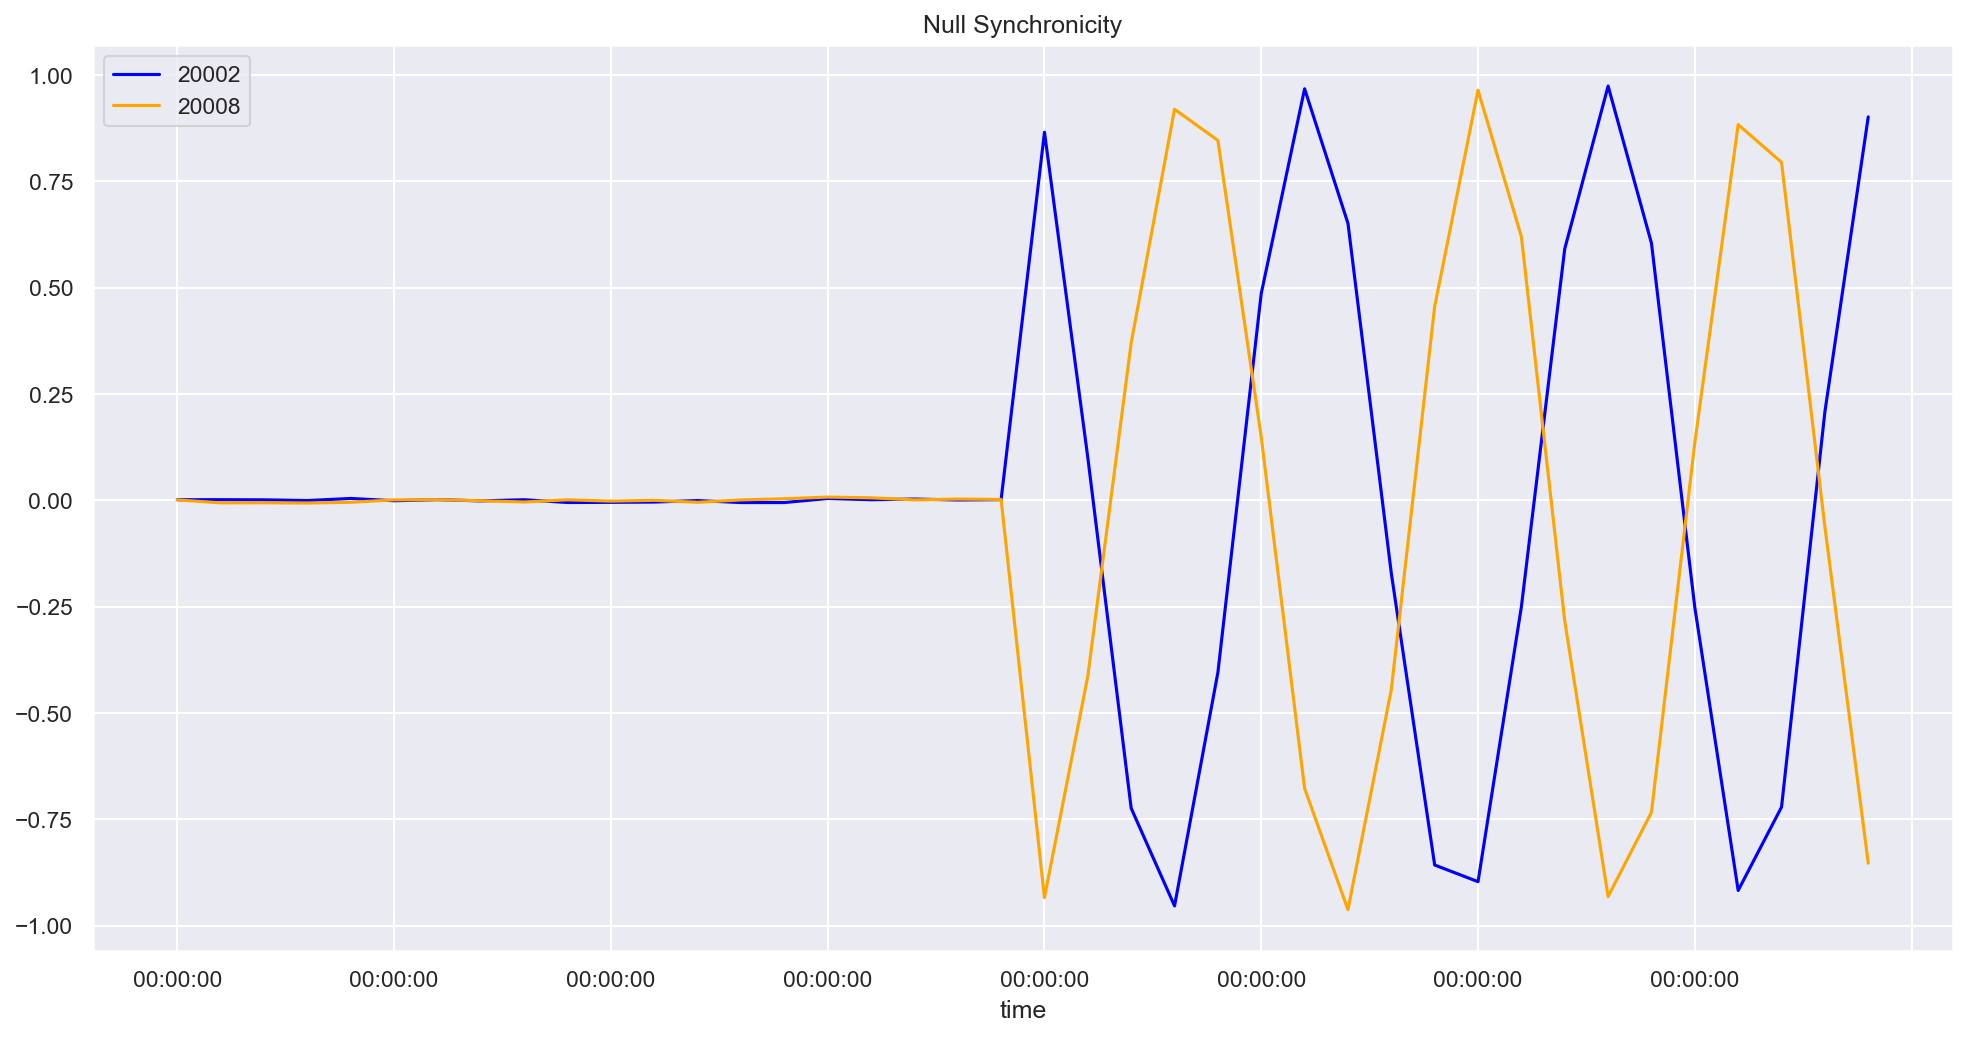

In [122]:
plt.figure(figsize=(16, 8), dpi=150)

# sync_df.loc[sync_df['sub'] == '20001'][frq].plot(label='20001', color = 'red')
null_sync_df.loc[null_sync_df['sub'] == '20002'][frq].plot(label='20002', color = 'blue')
# null_sync_df.loc[null_sync_df['sub'] == '20003'][frq].plot(label='20003', color = 'green')
# null_sync_df.loc[null_sync_df['sub'] == '20004'][frq].plot(label='20004', color = 'purple')
null_sync_df.loc[null_sync_df['sub'] == '20008'][frq].plot(label='20008', color = 'orange')
#     df.loc[df['sub'] == '20010'][x].plot(label='20010', color = 'black')

# adding title to the plot
plt.title('Null Synchronicity')

# adding Label to the x-axis
plt.xlabel('time')

# adding legend to the curve
plt.legend()

In [107]:
null_sync_df

,IMF4: 0.021–0.036 Hz,IMF3: 0.063–0.098 Hz,IMF2: 0.13–0.17 Hz,IMF1: 0.20–0.25 Hz,sub
time,,,,,
00:00:00,0.001195,0.001195,0.001195,0.001195,20008
00:00:00,-0.005677,-0.005677,-0.005677,-0.005677,20008
00:00:00,-0.005510,-0.005510,-0.005510,-0.005510,20008
00:00:00,-0.006044,-0.006044,-0.006044,-0.006044,20008
00:00:00,-0.004384,-0.004384,-0.004384,-0.004384,20008
...,...,...,...,...,...
00:00:00,0.858773,-0.216917,-0.048358,0.545132,20010
00:00:00,0.978930,-0.904289,0.848700,-0.730859,20010
00:00:00,0.994971,-0.740376,-0.494297,0.761116,20010


In [123]:
null_k_df = []
for sub, data in null_kura['dlPFC'].items():
    x = pd.DataFrame.from_dict(data)
    x['sub'] = sub
    x['time'] = time['HTH']
    x['time'] = pd.to_datetime(x['time'])
    x['time'] = x['time'].dt.strftime('%H:%M:%S')
    x = x.set_index('time')
    null_k_df.append(x)
null_kura_df = pd.concat(null_k_df)

In [124]:
null_kura_df

,IMF4: 0.021–0.036 Hz,IMF3: 0.063–0.098 Hz,IMF2: 0.13–0.17 Hz,IMF1: 0.20–0.25 Hz,sub
time,,,,,
00:00:00,0.001195,0.001195,0.001195,0.001195,20008
00:00:00,0.005677,0.005677,0.005677,0.005677,20008
00:00:00,0.005510,0.005510,0.005510,0.005510,20008
00:00:00,0.006044,0.006044,0.006044,0.006044,20008
00:00:00,0.004384,0.004384,0.004384,0.004384,20008
...,...,...,...,...,...
00:00:00,0.996561,0.970940,0.895252,0.756998,20010
00:00:00,0.997439,0.967762,0.887238,0.777151,20010
00:00:00,0.998070,0.965509,0.872047,0.761815,20010


20008
0
20001
1
20002
2
20003
3
20004
4
20010
5


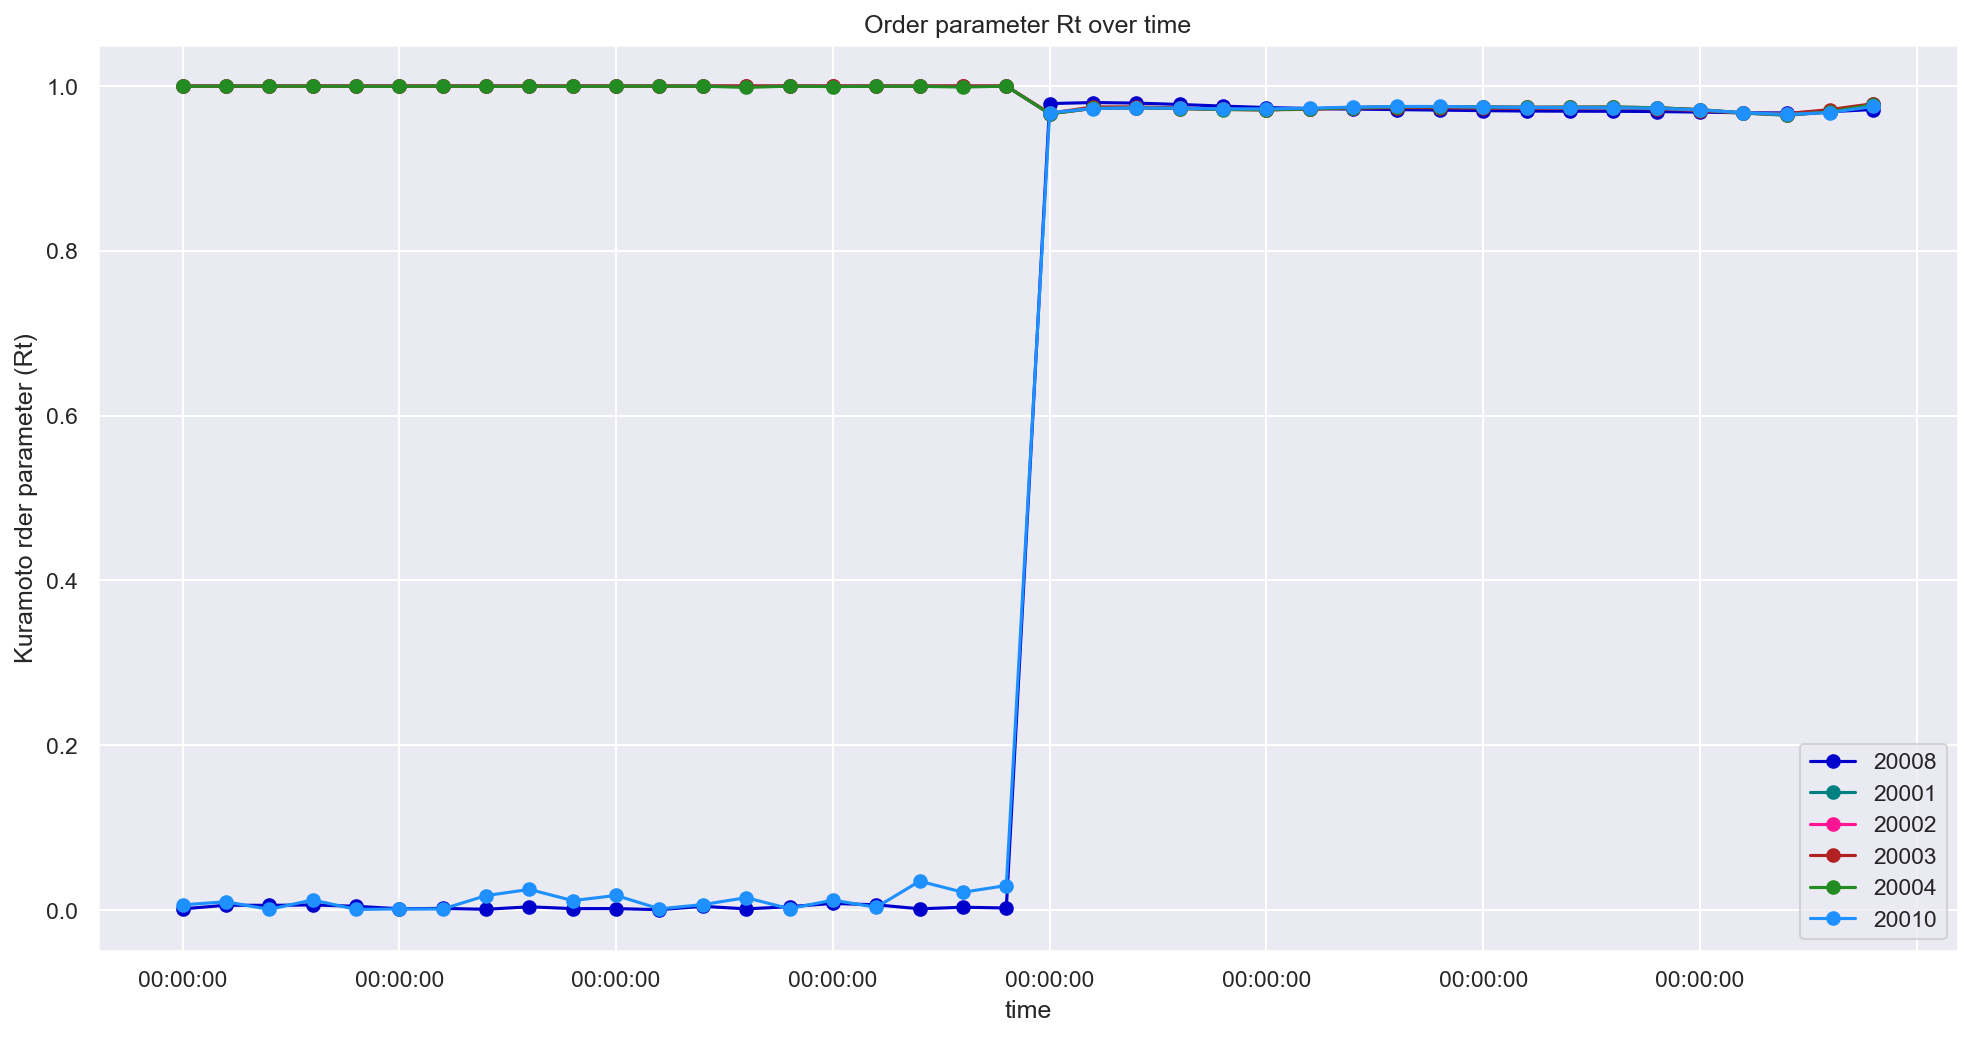

In [125]:
plt.figure(figsize=(16, 8), dpi=150, facecolor='white')
frq = 'IMF3: 0.063–0.098 Hz'
colors = ['mediumblue', 'teal','deeppink','firebrick','forestgreen','dodgerblue']
i = 0 
for sub, data in null_kura['dlPFC'].items():
    print(sub)
    print(i)
    null_kura_df.loc[null_kura_df['sub'] == sub][frq].plot(label='%s'%sub, color = '%s'%colors[i], marker = 'o')
    i = i+1

# adding title to the plot
plt.title('Order parameter Rt over time')

# adding Label to the x-axis
plt.xlabel('time')
plt.ylabel('Kuramoto rder parameter (Rt)')

# ax.set_facecolor('white')

# adding legend to the curve
plt.legend()

# Functional connectivity, ISPS

In [ ]:
kura_df.loc[kura_df['sub'] == sub][frq]

In [ ]:
n = 6
R = np.arange(0,1, .01)
Z = n*(R**2)
thr = 75
p = np.exp(-1*Z)*(1 + (2*Z - Z**2)/(4*n) - (24*Z - 132*Z**2 +76*Z**3 - 9*Z**4)/(288*n**2))

plt.figure(figsize=(12, 4))
plt.plot(R, p, linewidth=4)
plt.axhline(p[thr], linestyle='--', color='red')
plt.axvline(R[thr], linestyle='--', color='darkgrey')
plt.ylabel('p-Value', fontsize=18)
plt.xlabel('Synchrony (Resultant Vector)', fontsize=18)
plt.title('Rayleigh p-value Simulation for N=4', fontsize=20)
plt.legend(['ISPS Values', 'p < %s'%p[thr], 'ISPS = %s'%R[thr]])

In [ ]:
def bootstrap_subject_matrix(similarity_matrix, random_state=None):
    '''This function shuffles subjects within a similarity matrix based on recommendation by Chen et al., 2016'''
    
    random_state = check_random_state(random_state)
    n_sub = similarity_matrix.shape[0]
    bootstrap_subject = sorted(random_state.choice(np.arange(n_sub), size=n_sub, replace=True))
    return similarity_matrix[bootstrap_subject, :][:, bootstrap_subject]


In [ ]:
synchrony = {}
for roi in heady:
    sstats = isps(get_subject_roi(sub_timeseries, roi).dropna(), low_cut=0.01, high_cut=0.027, sampling_freq=1/tr)
    synchrony[roi] = sstats['vector_length']
synchrony = pd.DataFrame(synchrony)

In [ ]:
sync = Adjacency(1 - pairwise_distances(synchrony.T, metric='correlation'), matrix_type='similarity')

In [ ]:
syn = 1 - pairwise_distances(synchrony.T, metric='correlation')

In [ ]:
boots = []
for x in range(50000):
    X = bootstrap_subject_matrix(syn, random_state=x)
    boots.append(X)

In [ ]:
null = np.asarray(boots)

In [ ]:
output = np.mean(null, axis=0)

In [ ]:
from scipy import stats
ttest = stats.ttest_ind(syn, output,equal_var=False)







In [ ]:
# f,a = plt.subplots(nrows = len(frequencies), figsize=(15,10))
tr = 1
frequencies = [(0.01, 0.027),(0.027, 0.073),(0.073, 0.198),(0.198, 0.25),(64,200)]
sync_freq = {}
for i,cutoff in enumerate(frequencies):
    sync_freq[i] = {}
    for roi in heady:
        sync_freq[i][roi] = isps(get_subject_roi(sub_timeseries, roi).dropna(), low_cut=cutoff[0], high_cut=cutoff[1], sampling_freq=1/tr, order=5)['vector_length']
#     phase_synchrony_brain = roi_to_brain(pd.DataFrame(synchrony).mean(), mask_x)
#     phase_synchrony_brain.plot(cmap='RdBu_r', vmax=1, axes=a[i], threshold=R[thr], title=f"Frequency cutoff: {cutoff[0]} - {cutoff[1]}")
    
    
    
    
    
    
    

In [ ]:
sync_freq[2]['insulin_uIU_mL'] 

In [ ]:
frequencies[1]

In [ ]:
synchrony

In [ ]:
tr = 1
roi = 'insulin_uIU_mL'

f,a = plt.subplots(nrows = len(frequencies), figsize=(15,10))
for i,cutoff in enumerate(frequencies):
    synchrony = {}
    for roi in heady:
        synchrony[roi] = isps(get_subject_roi(sub_timeseries, roi).dropna(), low_cut=cutoff[0], high_cut=cutoff[1], sampling_freq=1/tr, order=5)['vector_length']
    phase_synchrony_brain = roi_to_brain(pd.DataFrame(synchrony).mean(), mask_x)
    phase_synchrony_brain.plot(cmap='RdBu_r', vmax=1, axes=a[i], threshold=R[thr], title=f"Frequency cutoff: {cutoff[0]} - {cutoff[1]}")


In [ ]:
f,a = plt.subplots(ncols=2, figsize=(12, 6))

sync.plot(vmin=-1, vmax=1, cmap='RdBu_r', axes=a[0], cbar=True)
sync.threshold(upper = .1, binarize=True).plot(axes=a[1], cbar=False)
a[0].set_title('ISPS Functional Connectivity Matrix', fontsize=18)
a[1].set_title('Thresholded ISPS Functional Connectivity Matrix', fontsize=18)
plt.tight_layout()

In [ ]:
heady[11]

In [ ]:
plot_network(sync.threshold(upper = .3, binarize=True))

In [ ]:
degree = pd.Series(dict(sync.threshold(upper=.2, binarize=True).to_graph().degree()))
brain_degree = roi_to_brain(degree, mask_x)
brain_degree.plot(cmap='RdBu_r')

https://www.frontiersin.org/articles/10.3389/fnins.2019.00900/full

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def plot_colortable(colors, title, sort_colors=True, emptycols=0):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12
    topmargin = 40

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
        names = [name for hsv, name in by_hsv]
    else:
        names = list(colors)

    n = len(names)
    ncols = 4 - emptycols
    nrows = n // ncols + int(n % ncols > 0)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + margin + topmargin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-topmargin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()
    ax.set_title(title, fontsize=24, loc="left", pad=10)

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

plot_colortable(mcolors.BASE_COLORS, "Base Colors",
                sort_colors=False, emptycols=1)
plot_colortable(mcolors.TABLEAU_COLORS, "Tableau Palette",
                sort_colors=False, emptycols=2)

plot_colortable(mcolors.CSS4_COLORS, "CSS Colors")

# Optionally plot the XKCD colors (Caution: will produce large figure)
# xkcd_fig = plot_colortable(mcolors.XKCD_COLORS, "XKCD Colors")
# xkcd_fig.savefig("XKCD_Colors.png")

plt.show()

Make viz figure too, make null models to compare the synchonicity 